In [1]:
# @title Install and import dependencies

# %tensorflow_version 2.x
# pip install -qU ddsp

# Ignore a bunch of deprecation warnings
import warnings

warnings.filterwarnings("ignore")

import ddsp
# import ddsp.training
# from ddsp.colab.colab_utils import play, specplot, DEFAULT_SAMPLE_RATE
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# IMPORTS MINE:
import sounddevice as sd
import time as stime

DEFAULT_SAMPLE_RATE = 16000
sample_rate = DEFAULT_SAMPLE_RATE  # 16000



In [2]:
### my Functions:
def playsound(inputsound):
    sd.play(inputsound[0], DEFAULT_SAMPLE_RATE)
    stime.sleep(len(inputsound[0])/DEFAULT_SAMPLE_RATE)
    sd.stop()


def Myspecplot(inputsound):
    plot = plt.figure(figsize=(4, 4))
    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(inputsound[0], Fs=DEFAULT_SAMPLE_RATE)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    return plot   

In [3]:
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size

# Create a synthesizer object.
additive_synth = ddsp.synths.Additive(
    n_samples=n_samples, sample_rate=sample_rate, name="additive_synth"
)

In [4]:
# Generate some arbitrary inputs.

# Amplitude [batch, n_frames, 1].
# Make amplitude linearly decay over time.
amps = np.linspace(1.0, -3.0, n_frames)
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
# Make harmonics decrease linearly with frequency.
n_harmonics = 30
harmonic_distribution = (
    np.linspace(-2.0, 2.0, n_frames)[:, np.newaxis]
    + np.linspace(3.0, -3.0, n_harmonics)[np.newaxis, :]
)
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = 440.0 * np.ones([1, n_frames, 1], dtype=np.float32)

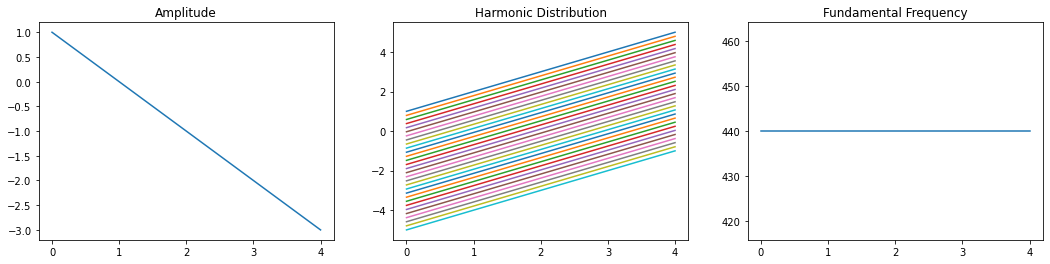

In [5]:
# Plot it!
time = np.linspace(0, n_samples / sample_rate, n_frames)

plot_0 = plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, amps[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title("Amplitude")

plt.subplot(132)
plt.plot(time, harmonic_distribution[0, :, :])
plt.xticks([0, 1, 2, 3, 4])
plt.title("Harmonic Distribution")

plt.subplot(133)
plt.plot(time, f0_hz[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
_ = plt.title("Fundamental Frequency")
plot_0.show()

dict_keys(['amplitudes', 'harmonic_distribution', 'f0_hz'])


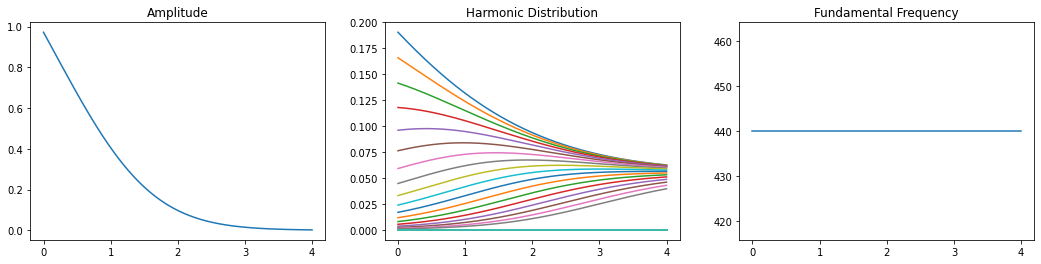

In [6]:
controls = additive_synth.get_controls(amps, harmonic_distribution, f0_hz)
print(controls.keys())


# Now let's see what they look like...
time = np.linspace(0, n_samples / sample_rate, n_frames)

plot_1 = plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, controls["amplitudes"][0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title("Amplitude")

plt.subplot(132)
plt.plot(time, controls["harmonic_distribution"][0, :, :])
plt.xticks([0, 1, 2, 3, 4])
plt.title("Harmonic Distribution")

plt.subplot(133)
plt.plot(time, controls["f0_hz"][0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
_ = plt.title("Fundamental Frequency")

plot_1.show()

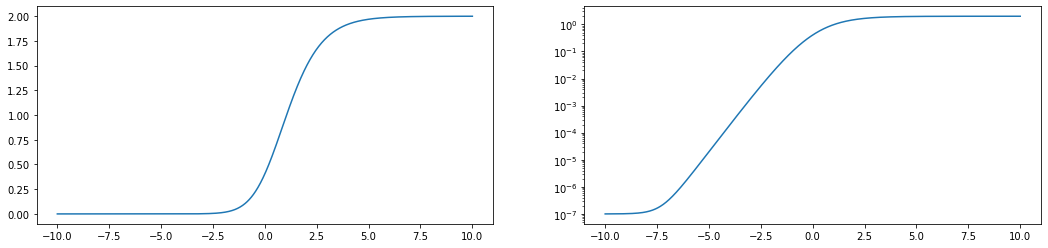

In [7]:
x = tf.linspace(-10.0, 10.0, 1000)
y = ddsp.core.exp_sigmoid(x)

plot_2 = plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.plot(x, y)

plt.subplot(122)
_ = plt.semilogy(x, y)
plot_2.show()

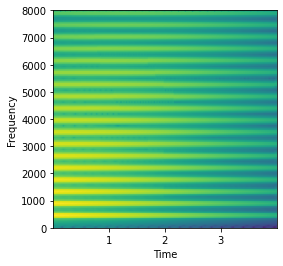

In [8]:
audio = additive_synth.get_signal(**controls)
playsound(audio)
plot_3 = Myspecplot(audio)
plot_3.show()

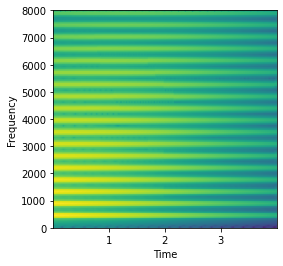

In [9]:
audio = additive_synth(amps, harmonic_distribution, f0_hz)

playsound(audio)
plot_4 = Myspecplot(audio)
plot_4.show()


In [10]:
## Some weird control envelopes...

# Amplitude [batch, n_frames, 1].
amps = np.ones([n_frames]) * -5.0
amps[:50] +=  np.linspace(0, 7.0, 50)
amps[50:200] += 7.0
amps[200:900] += (7.0 - np.linspace(0.0, 7.0, 700))
amps *= np.abs(np.cos(np.linspace(0, 2*np.pi * 10.0, n_frames)))
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
for i in range(n_harmonics):
  harmonic_distribution[:, i] = 1.0 - np.linspace(i * 0.09, 2.0, 1000)
  harmonic_distribution[:, i] *= 5.0 * np.abs(np.cos(np.linspace(0, 2*np.pi * 0.1 * i, n_frames)))
  if i % 2 != 0:
    harmonic_distribution[:, i] = -3
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = np.ones([n_frames]) * 200.0
f0_hz[:100] *= np.linspace(2, 1, 100)**2
f0_hz[200:1000] += 20 * np.sin(np.linspace(0, 8.0, 800) * 2 * np.pi * np.linspace(0, 1.0, 800))  * np.linspace(0, 1.0, 800)
f0_hz = f0_hz[np.newaxis, :, np.newaxis]

# Get valid controls
controls = additive_synth.get_controls(amps, harmonic_distribution, f0_hz)